# 09. Aggregated HDBSCAN Clustering

HDBSCAN clustering at three aggregation levels:
1. **Buyers** - cluster buyers by procurement behavior patterns
2. **Suppliers** - cluster suppliers by winning patterns (detect cartels)
3. **Buyer-Supplier Pairs** - cluster relationships (detect collusion)

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers
from src.detectors import AggregatedHDBSCAN

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-01-31 12:02:15


## 1. Load Data

In [2]:
tenders = load_tenders(years=[2022, 2023, 2024, 2025])
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Tenders: {len(tenders):,}")
print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Loaded buyers: 35,995
Loaded suppliers: 358,376
Tenders: 12,877,960
Buyers: 35,995
Suppliers: 358,376


## 2. Initialize Detector

In [3]:
detector = AggregatedHDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    metric="euclidean",
)

## 3. Cluster Buyers

Find groups of buyers with similar procurement patterns. Outliers = suspicious buyers.

In [4]:
buyer_results = detector.cluster_buyers(tenders, buyers)

Clustering BUYERS...
  Using pre-computed buyer features
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_tender_value', 'total_value']
  Buyers: 35,995
  Clusters: 413
  Noise (outliers): 18,031 (50.1%)
  Anomalies (score>=0.5): 18,570 (51.6%)


In [5]:
print("\nBuyer clustering results:")
print(f"  Total buyers: {len(buyer_results):,}")
print(f"  Clusters: {buyer_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {buyer_results['is_noise'].sum():,}")
print(f"  Anomalies: {buyer_results['is_anomaly'].sum():,}")


Buyer clustering results:
  Total buyers: 35,995
  Clusters: 413
  Noise (outliers): 18,031
  Anomalies: 18,570


In [6]:
# Suspicious buyers (high outlier score)
suspicious_buyers = detector.get_suspicious_buyers(min_score=0.5)
print(f"\nSuspicious buyers (score >= 0.5): {len(suspicious_buyers):,}")

if len(suspicious_buyers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_buyers.nlargest(10, 'outlier_score'))


Suspicious buyers (score >= 0.5): 18,570

Top 10 by outlier score:


,buyer_id,cluster,probability,outlier_score,is_noise,is_anomaly,single_bidder_rate,competitive_rate,avg_discount_pct,supplier_diversity_index,total_tenders,avg_tender_value,total_value
0,40295882,-1,0.0,1.0,1,1,0.000334,0.000788,0.042697,0.016495,64226,2.966827e+03,3.201191e+09
1,38357766,-1,0.0,1.0,1,1,0.001007,0.003526,0.117540,0.073036,34945,1.191828e+04,2.950025e+08
2,39776588,-1,0.0,1.0,1,1,0.001285,0.001820,0.048113,0.103330,14186,1.983008e+04,2.832284e+08
3,41076819,-1,0.0,1.0,1,1,0.000161,0.000000,0.000515,0.071337,13377,1.631100e+04,2.187065e+08
4,38313100,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,12330,0.000000e+00,3.961513e+07
5,38351628,-1,0.0,1.0,1,1,0.000246,0.003197,0.075250,0.130841,10927,1.836483e+04,1.745288e+08
6,03767831,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,10052,0.000000e+00,2.614186e+09
7,21560045,-1,0.0,1.0,1,1,0.160263,0.240647,6.656740,0.452477,9972,2.144476e+06,1.779480e+10
8,38324552,-1,0.0,1.0,1,1,0.000000,0.000000,0.000000,0.000000,9708,0.000000e+00,2.906917e+07
9,19122935,-1,0.0,1.0,1,1,0.005405,0.015135,0.328641,0.033153,9699,1.261466e+04,9.233682e+07


In [7]:
# Compare suspicious vs normal buyers
if len(suspicious_buyers) > 0 and 'single_bidder_rate' in buyer_results.columns:
    normal_buyers = buyer_results[buyer_results['outlier_score'] < 0.5]
    
    print("Comparison: Suspicious vs Normal Buyers")
    print("="*50)
    
    for col in ['single_bidder_rate', 'competitive_rate', 'total_value']:
        if col in buyer_results.columns:
            sus_mean = suspicious_buyers[col].mean()
            norm_mean = normal_buyers[col].mean()
            print(f"{col}:")
            print(f"  Suspicious: {sus_mean:.3f}")
            print(f"  Normal:     {norm_mean:.3f}")

Comparison: Suspicious vs Normal Buyers
single_bidder_rate:
  Suspicious: 0.056
  Normal:     0.012
competitive_rate:
  Suspicious: 0.054
  Normal:     0.015
total_value:
  Suspicious: 183149734.765
  Normal:     23978523.905


## 4. Cluster Suppliers

Find groups of suppliers with similar winning patterns. Outliers = potential cartel members or anomalous suppliers.

In [8]:
supplier_results = detector.cluster_suppliers(tenders, suppliers)

Clustering SUPPLIERS...
  Computing supplier features from tenders (Polars)...
  Features: ['total_awards', 'total_value', 'avg_award_value', 'buyer_count', 'single_bidder_rate', 'avg_competitors']
  Suppliers: 358,377
  Clusters: 9509
  Noise (outliers): 101,421 (28.3%)
  Anomalies (score>=0.5): 127,305 (35.5%)


In [9]:
print("\nSupplier clustering results:")
print(f"  Total suppliers: {len(supplier_results):,}")
print(f"  Clusters: {supplier_results['cluster'].nunique() - 1}")
print(f"  Noise (outliers): {supplier_results['is_noise'].sum():,}")
print(f"  Anomalies: {supplier_results['is_anomaly'].sum():,}")


Supplier clustering results:
  Total suppliers: 358,377
  Clusters: 9509
  Noise (outliers): 101,421
  Anomalies: 127,305


In [10]:
# Suspicious suppliers
suspicious_suppliers = detector.get_suspicious_suppliers(min_score=0.5)
print(f"\nSuspicious suppliers (score >= 0.5): {len(suspicious_suppliers):,}")

if len(suspicious_suppliers) > 0:
    print("\nTop 10 by outlier score:")
    display(suspicious_suppliers.nlargest(10, 'outlier_score'))


Suspicious suppliers (score >= 0.5): 127,305

Top 10 by outlier score:


,supplier_id,cluster,probability,outlier_score,is_noise,is_anomaly,total_awards,total_value,avg_award_value,buyer_count,single_bidder_rate,avg_competitors
1,41618701,1563,0.0,1.0,0,1,1,8.399592e+04,8.399592e+04,1,0.000000,0.000000
4,45684584,-1,0.0,1.0,1,1,7,2.461950e+05,3.517071e+04,4,0.000000,0.000000
5,34811402,-1,0.0,1.0,1,1,70,1.005495e+08,1.436422e+06,20,0.157143,0.157143
6,1773403505,-1,0.0,1.0,1,1,65,1.669230e+06,2.568046e+04,5,0.000000,0.000000
7,40333641,-1,0.0,1.0,1,1,100,6.283560e+07,6.283560e+05,16,0.000000,0.000000
10,2133203416,-1,0.0,1.0,1,1,36,1.769751e+05,4.915975e+03,6,0.000000,0.000000
11,2795201847,-1,0.0,1.0,1,1,102,8.915027e+05,8.740222e+03,22,0.000000,0.000000
13,3123925752,-1,0.0,1.0,1,1,27,6.964466e+05,2.579432e+04,3,0.037037,0.037037
17,3118008656,-1,0.0,1.0,1,1,6,3.992999e+05,6.654998e+04,6,0.000000,0.000000
19,45195995,-1,0.0,1.0,1,1,146,4.552327e+06,3.118032e+04,52,0.000000,0.000000


In [11]:
# Supplier clusters analysis
print("\nSupplier Cluster Analysis:")
print("="*50)

cluster_stats = supplier_results.groupby('cluster').agg({
    'supplier_id': 'count',
    'total_awards': 'mean',
    'total_value': 'mean',
    'single_bidder_rate': 'mean',
}).round(2)
cluster_stats.columns = ['count', 'avg_awards', 'avg_value', 'single_bidder_rate']
cluster_stats = cluster_stats.sort_values('count', ascending=False)

display(cluster_stats.head(10))


Supplier Cluster Analysis:


,count,avg_awards,avg_value,single_bidder_rate
cluster,,,,
-1,101421,98.16,35909000.18,0.09
9185,3041,46.31,668089.70,0.00
9209,2251,40.06,636596.68,0.00
9294,1643,53.61,762978.79,0.00
3762,1003,1.00,10000.00,0.00
9324,947,51.42,722074.54,0.00
0,890,23.65,8489108.04,0.07
3811,887,1.00,5000.00,0.00
3897,817,1.00,20000.00,0.00


## 5. Cluster Buyer-Supplier Pairs

Find groups of relationships with similar patterns. Outliers = suspicious collusive relationships.

In [12]:
pair_results = detector.cluster_pairs(tenders, min_contracts=3)

Clustering BUYER-SUPPLIER PAIRS...
  Computing pair features from tenders (Polars)...
  Pairs with 3+ contracts: 916,278
  Features: ['contracts_count', 'total_value', 'avg_value', 'single_bidder_rate', 'exclusivity_buyer', 'exclusivity_supplier']
  Clusters: 7930
  Noise (outliers): 606,407 (66.2%)
  Anomalies (score>=0.5): 607,039 (66.3%)


In [13]:
if len(pair_results) > 0:
    print("\nBuyer-Supplier pair clustering results:")
    print(f"  Total pairs: {len(pair_results):,}")
    print(f"  Clusters: {pair_results['cluster'].nunique() - 1}")
    print(f"  Noise (outliers): {pair_results['is_noise'].sum():,}")
    print(f"  Anomalies: {pair_results['is_anomaly'].sum():,}")


Buyer-Supplier pair clustering results:
  Total pairs: 916,278
  Clusters: 7930
  Noise (outliers): 606,407
  Anomalies: 607,039


In [14]:
# Suspicious pairs (potential collusion)
if len(pair_results) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(min_score=0.5)
    print(f"\nSuspicious pairs (score >= 0.5): {len(suspicious_pairs):,}")

    if len(suspicious_pairs) > 0:
        print("\nTop 10 suspicious pairs by outlier score:")
        display(suspicious_pairs.nlargest(10, 'outlier_score')[[
            'buyer_id', 'supplier_id', 'outlier_score', 
            'contracts_count', 'total_value', 'single_bidder_rate',
            'exclusivity_buyer', 'exclusivity_supplier'
        ]])


Suspicious pairs (score >= 0.5): 607,039

Top 10 suspicious pairs by outlier score:


,buyer_id,supplier_id,outlier_score,contracts_count,total_value,single_bidder_rate,exclusivity_buyer,exclusivity_supplier
0,04058380,2343705248,1.0,9,34055.00,0.0,0.030100,0.642857
1,43664739,37511331,1.0,9,91191.40,0.0,0.005988,0.105882
2,01562987,43395033,1.0,3,13566.00,0.0,0.006329,0.001139
4,42140037,2181511321,1.0,3,2950.00,0.0,0.005714,0.012048
6,01997461,2001214626,1.0,7,14739.00,0.0,0.005719,0.045161
8,37308938,32660496,1.0,3,7602.01,0.0,0.002429,0.081081
9,08113086,30730524,1.0,7,23892.47,0.0,0.017115,0.040462
10,02547286,21560766,1.0,3,22112.00,0.0,0.010714,0.000058
12,26227793,2780011959,1.0,3,929000.00,0.0,0.006849,0.069767
13,03491180,32319395,1.0,3,3826.88,0.0,0.003436,0.025424


In [15]:
# Highly exclusive relationships (potential red flags)
if len(pair_results) > 0:
    exclusive_pairs = pair_results[
        (pair_results['exclusivity_buyer'] > 0.5) | 
        (pair_results['exclusivity_supplier'] > 0.5)
    ]
    print(f"\nHighly exclusive relationships (>50% exclusivity): {len(exclusive_pairs):,}")
    
    if len(exclusive_pairs) > 0:
        print("\nTop 10 by buyer exclusivity:")
        display(exclusive_pairs.nlargest(10, 'exclusivity_buyer')[[
            'buyer_id', 'supplier_id', 'contracts_count', 'total_value',
            'exclusivity_buyer', 'exclusivity_supplier', 'single_bidder_rate'
        ]])


Highly exclusive relationships (>50% exclusivity): 92,216

Top 10 by buyer exclusivity:


,buyer_id,supplier_id,contracts_count,total_value,exclusivity_buyer,exclusivity_supplier,single_bidder_rate
244,3165704792,2039814704,3,1940000.00,1.0,1.000000,1.0
8067,39378635,22830943,3,372767.00,1.0,0.020270,0.0
12556,43023733,3218315672,9,403000.00,1.0,0.074380,0.0
20304,40715544,45076326,3,149850.00,1.0,0.111111,0.0
24987,44222289,3110820289,4,135846.00,1.0,0.800000,0.0
31812,41361662,2712713895,3,177000.00,1.0,0.004680,0.0
32408,20520167,2758313591,3,168673.82,1.0,0.035714,0.0
39728,43499705,42114410,7,1186000.00,1.0,0.001840,0.0
42801,39969773,22360472,7,9125.18,1.0,0.002713,0.0
52381,26342287,2875612351,11,549438.00,1.0,1.000000,0.0


## 6. Summary

In [16]:
summaries = detector.summary()

for level, summary_df in summaries.items():
    print(f"\n{level.upper()} Summary:")
    print("="*40)
    display(summary_df)


BUYERS Summary:


,metric,value
0,total,35995.000000
1,clusters,414.000000
2,noise,18031.000000
3,noise_pct,50.093068
4,anomalies,18570.000000
5,anomaly_pct,51.590499



SUPPLIERS Summary:


,metric,value
0,total,358377.000000
1,clusters,9510.000000
2,noise,101421.000000
3,noise_pct,28.300086
4,anomalies,127305.000000
5,anomaly_pct,35.522648



PAIRS Summary:


,metric,value
0,total,916278.000000
1,clusters,7931.000000
2,noise,606407.000000
3,noise_pct,66.181552
4,anomalies,607039.000000
5,anomaly_pct,66.250527


## 7. Visualizations

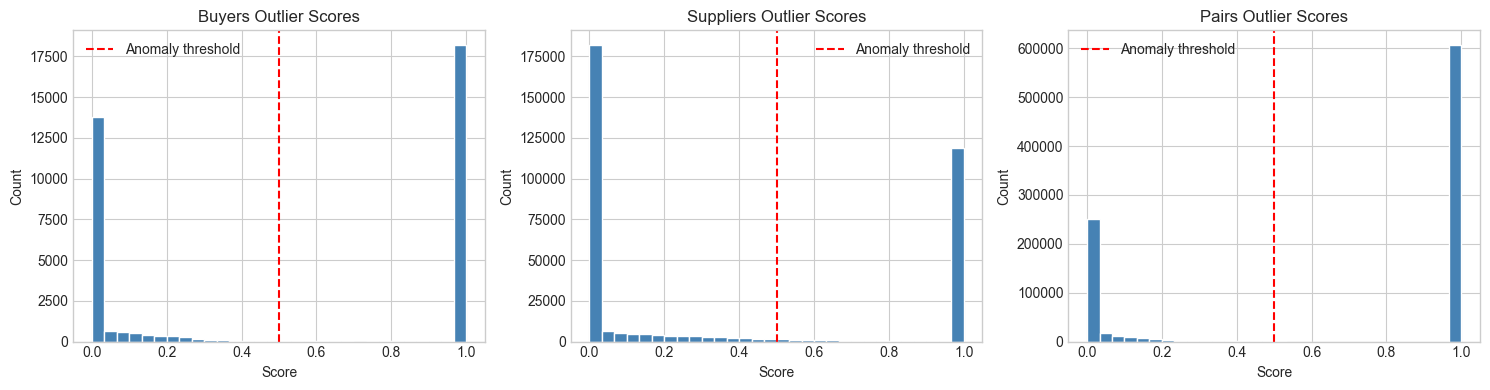

In [17]:
# Outlier score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        results['outlier_score'].hist(bins=30, ax=ax, color='steelblue', edgecolor='white')
        ax.axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
        ax.set_title(f'{name} Outlier Scores')
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Outlier Scores')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_scores.png', dpi=150, bbox_inches='tight')
plt.show()

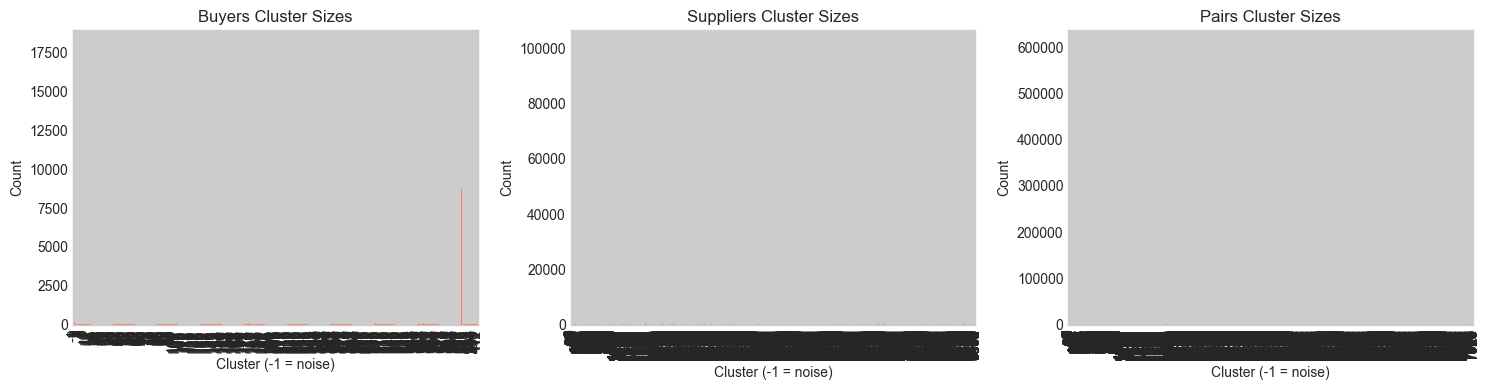

In [18]:
# Cluster sizes
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, results) in zip(axes, [
    ('Buyers', detector.buyer_results_),
    ('Suppliers', detector.supplier_results_),
    ('Pairs', detector.pair_results_),
]):
    if results is not None and len(results) > 0:
        cluster_sizes = results['cluster'].value_counts().sort_index()
        cluster_sizes.plot(kind='bar', ax=ax, color='coral')
        ax.set_title(f'{name} Cluster Sizes')
        ax.set_xlabel('Cluster (-1 = noise)')
        ax.set_ylabel('Count')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{name} Cluster Sizes')

plt.tight_layout()
plt.savefig('../results/aggregated_hdbscan_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Results

In [19]:
# Save anomalies from each level
if detector.buyer_results_ is not None:
    suspicious_buyers = detector.get_suspicious_buyers(0.5)
    suspicious_buyers.to_csv('../results/hdbscan_suspicious_buyers.csv', index=False)
    print(f"Saved {len(suspicious_buyers)} suspicious buyers")

if detector.supplier_results_ is not None:
    suspicious_suppliers = detector.get_suspicious_suppliers(0.5)
    suspicious_suppliers.to_csv('../results/hdbscan_suspicious_suppliers.csv', index=False)
    print(f"Saved {len(suspicious_suppliers)} suspicious suppliers")

if detector.pair_results_ is not None and len(detector.pair_results_) > 0:
    suspicious_pairs = detector.get_suspicious_pairs(0.5)
    suspicious_pairs.to_csv('../results/hdbscan_suspicious_pairs.csv', index=False)
    print(f"Saved {len(suspicious_pairs)} suspicious pairs")

print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Saved 18570 suspicious buyers
Saved 127305 suspicious suppliers
Saved 607039 suspicious pairs

Completed: 2026-01-31 12:05:11
